|序号|变量名称|描述|
|------------|-------------|----------------------|
| 1 | 城市 | 房屋所在城市 |
| 2 | 区域 | 房屋所在县/市/区 |
| 3 | 板块 | 房屋所在板块（城市、区域、板块为包含关系） |
| 4 | 环线 | 房屋相对于城市重要环线/主干道路的位置 |
| 5 | 小区名称 | 房屋所属小区名称 |
| 6 | 价格 | 房屋成交价格 |
| 7 | 房屋户型 | 房屋户型（包含卧室数量、客厅数量、厨房数量、卫生间数量等信息） |
| 8 | 所在楼层 | 房屋所在楼层（包含总楼层信息） |
| 9 | 建筑面积 | 房屋建筑面积（套内面积+公摊面积） |
| 10 | 套内面积 | 房屋套内面积 |
| 11 | 房屋朝向 | 房屋朝向（存在多朝向房屋） |
| 12 | 建筑结构 | 房屋建筑主体构造 |
| 13 | 装修情况 | 房屋交易时装修情况 |
| 14 | 梯户比例 | 电梯数量与每层住户数量比例 |
| 15 | 配备电梯 | 楼层是否配备电梯 |
| 16 | 别墅类型 | 别墅的建筑风格和建筑形式（非别墅房屋为空值） |
| 17 | 交易时间 | 房屋成交时间 |
| 18 | 交易权属 | 房屋交易权属（商品房，已购公房等） |
| 19 | 上次交易 | 上次交易时间 |
| 20 | 房屋用途 | 房屋用途（普通住宅，商用住宅，商住两用等） |
| 21 | 房屋年限 | 房屋首次购买过户到交易时间年限 |
| 22 | 产权所属 | 房屋所有权人（共有、非） |
| 23 | 抵押信息 | 房屋抵押信息（是否用于抵押贷款等，无抵押信息为空） |
| 24 | 房屋优势 | 自然语言描述，针对房屋总体优势进行总结 |
| 25 | 核心卖点 | 自然语言描述，针对房屋卖点进行详细描述 |
| 26 | 户型介绍 | 自然语言描述，针对户型、朝向、楼层等信息进行描述 |
| 27 | 周边配套 | 自然语言描述，针对房屋周边商场、学校、医院等描述 |
| 28 | 交通出行 | 自然语言描述，针对房屋周边交通情况描述，包括地铁、公交、主干道等 |
| 29 | lon | 房屋所在经度 |
| 30 | lat | 房屋所在维度 |
| 31 | 年份 | 房屋登记时间 |

127
Index(['城市', '区域', '板块', '环线', '小区名称', '价格', '房屋户型', '所在楼层', '建筑面积', '套内面积',
       '房屋朝向', '建筑结构', '装修情况', '梯户比例', '配备电梯', '别墅类型', '交易时间', '交易权属', '上次交易',
       '房屋用途', '房屋年限', '产权所属', '房屋优势', '核心卖点', '户型介绍', '周边配套', '交通出行', 'lon',
       'lat', '年份', 'ID', '供热费', '燃气费', '停车位', '停车费用', '容 积 率', '绿 化 率',
       '物 业 费', '租金'],
      dtype='object') (84133, 39) (14786, 39) (98919, 39)


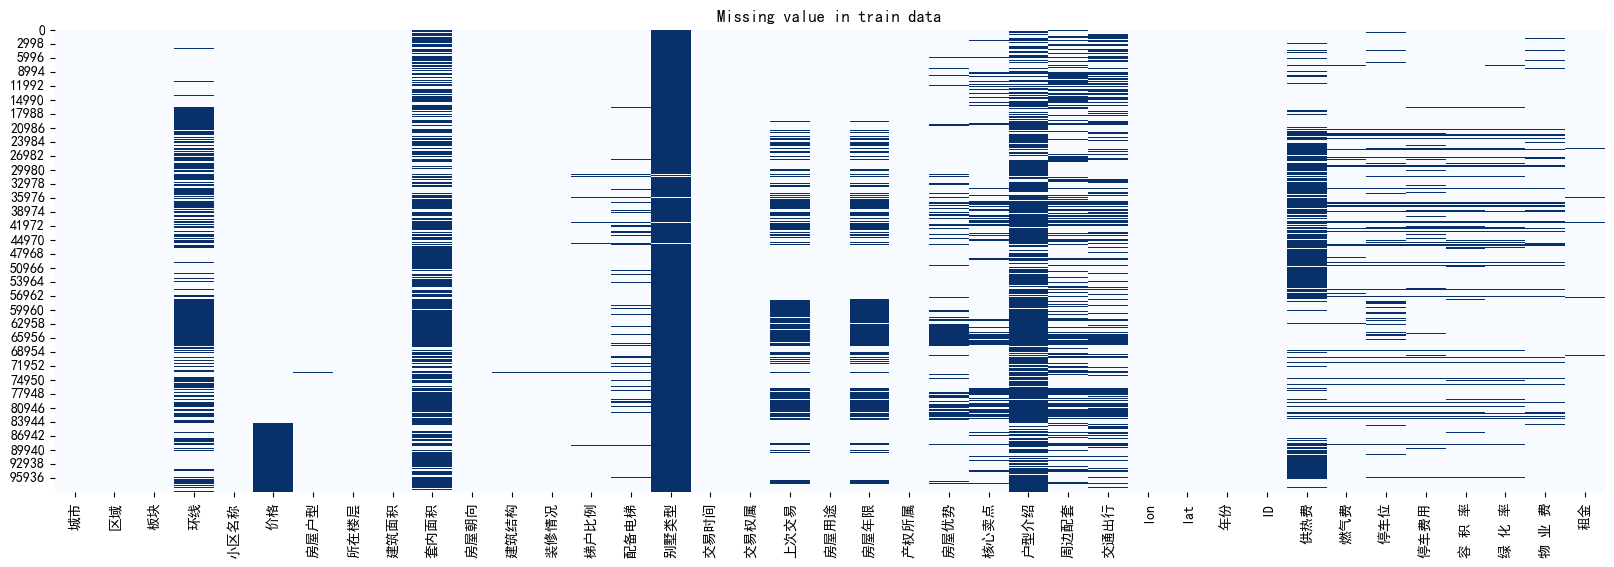

In [346]:
import re
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import geopandas as gpd
from shapely.geometry import Point
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import MinMaxScaler
import warnings
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")

train_file = 'data/ruc_Class25Q1_train.csv'
test_file = 'data/ruc_Class25Q1_test.csv'
rent_file = 'data/ruc_Class25Q1_rent.csv'
details_file = 'data/ruc_Class25Q1_details.csv'
rent_df = pd.read_csv(rent_file);rent_df['租金']=rent_df['价格']
details_df = pd.read_csv(details_file)
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

test_df = test_df.drop(columns=['抵押信息'])
train_df['ID'] = -1
# 检查重复的小区名称
print(details_df['名称'].duplicated().sum())
# 如果有重复，去重
details_df = details_df.drop_duplicates(subset=['名称'])
rent_df = rent_df.drop_duplicates(subset=['小区名称'])

temp1 = details_df[["名称", "供热费", "燃气费", "停车位", "停车费用", "容 积 率", "绿 化 率", "物 业 费"]]
train_df = pd.merge(train_df, temp1, left_on="小区名称", right_on="名称", how="left")
test_df = pd.merge(test_df, temp1, left_on="小区名称", right_on="名称", how="left")
train_df.drop(["名称"], axis=1, inplace=True)
test_df.drop(["名称"], axis=1, inplace=True)
temp2 = rent_df[["小区名称", "租金"]]
train_df = pd.merge(train_df, temp2, on="小区名称", how="left")
test_df = pd.merge(test_df, temp2, on="小区名称", how="left")


df = pd.concat([train_df, test_df], ignore_index=True) 
df = df.drop(['Unnamed: 0'], axis=1)
train_df = df[df['ID'] == -1]
pred_df = df[df['ID'] != -1]
print(df.columns,train_df.shape, pred_df.shape,df.shape)
plt.figure(figsize=(20, 6))
sns.heatmap(df.isnull(), cmap='Blues', cbar=False)
plt.title("Missing value in train data")
plt.show()

<Axes: xlabel='lon', ylabel='lat'>

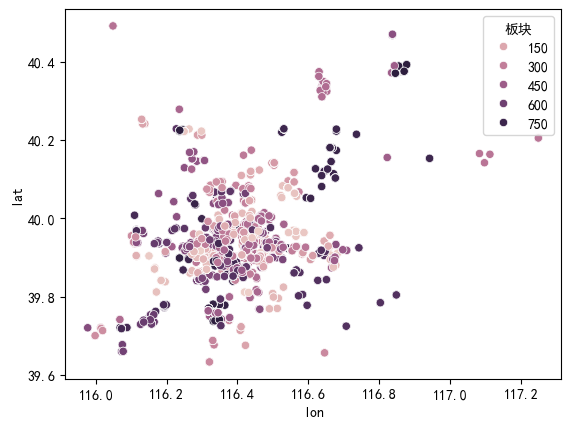

In [347]:
sns.scatterplot(y='lat',x='lon',data = df[df['城市']==0],hue='板块')

In [348]:
def class2onehot(df,col):
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    dropped_col = df[col]
    df.drop(col, axis=1, inplace=True)
    # 防止多重共线性
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, dropped_col
chinese2num_dict = {
    '一': 1,
    '二': 2,
    '两': 2,
    '三': 3,
    '四': 4,
    '五': 5,
    '六': 6,
    '七': 7,
    '八': 8,
    '九': 9,
    '十': 10,
    '十一': 11,
    '十二': 12,
    '十三': 13,
    '十四': 14,
    '十五': 15,
    '十六': 16,
    '十七': 17,
    '十八': 18,
    '十九': 19,
    '二十': 20,
    '二十一': 21,
    '二十二': 22,
    '二十三': 23,
    '二十四': 24,
    '二十五': 25,
    '二十六': 26,
    '二十七': 27,
    '二十八': 28,
    '二十九': 29,
    '三十': 30,
    '三十一': 31,
    '三十二': 32,
    '三十三': 33,
    '三十四': 34,
    '三十五': 35,
    '三十六': 36,
    '三十七': 37,
    '三十八': 38,
    '三十九': 39,
    '四十': 40,
    '四十一': 41,
    '四十二': 42,
    '四十三': 43,
    '四十四': 44,
    '四十五': 45,
    '四十六': 46,
    '四十七': 47,
    '四十九': 49,
    '五十': 50,
    '五十一': 51,
    '五十二': 52,
    '五十三': 53,
    '五十四': 54,
    '五十五': 55,
    '五十六': 56,
    '五十七': 57,
    '五十八': 58,
    '五十九': 59,
    '六十': 60,
    '六十一': 61,
    '六十二': 62,
    '六十三': 63,
    '六十四': 64,
    '六十五': 65,
    '六十六': 66,
    '六十七': 67,
    '六十八': 68,
    '六十九': 69,
    '七十': 70,
    '七十一': 71,
    '七十二': 72,
    '七十三': 73,
    '七十四': 74,
    '七十五': 75,
    '七十六': 76,
    '七十七': 77,
    '七十八': 78,
    '七十九': 79,
    '八十': 80,
    '八十一': 81,
    '八十二': 82,
    '八十三': 83,
    '八十四': 84,
    '八十五': 85,
    '八十六': 86,
    '八十七': 87,
    '八十八': 88,
    '八十九': 89,
    '九十': 90,
    '九十一': 91,
    '九十二': 92,
    '九十三': 93,
    '九十四': 94,
    '九十五': 95,
    '九十六': 96,
    '九十七': 97,
    '九十八': 98,
    '九十九': 99,
    '一百': 100
    }

1、城市：
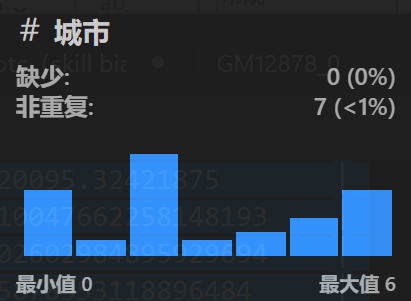

In [349]:
df ,city_col= class2onehot(df,'城市')
df = pd.concat([df, city_col], axis=1)
df.shape

(98919, 45)

2~3、区域、板块：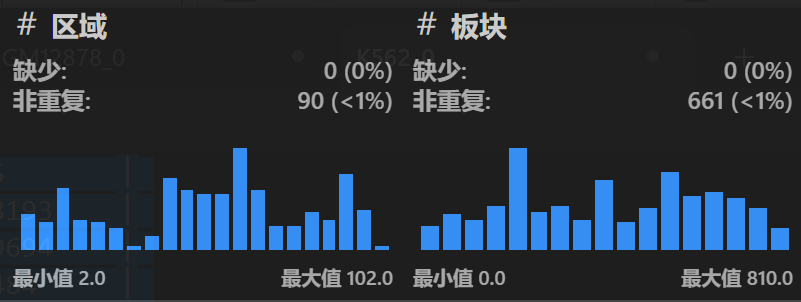

In [350]:
df = df.drop(['区域','板块'], axis=1)

4、环线：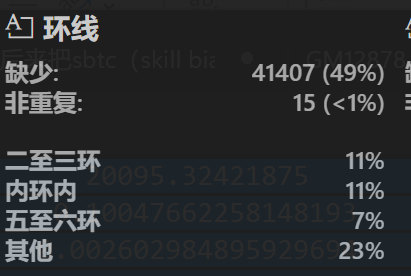

In [351]:
# print(df['环线'].unique())
# ['二至三环' '五至六环' '三至四环' '四至五环' '六环外' nan '二环内' '内环内' '内环至外环' '外环外' '中环至外环' '内环至中环' '一至二环' '一环内' '四环外' '三环外']
line2num_dict = {
    '二至三环': 2,
    '五至六环': 5,
    '三至四环': 3,
    '四至五环': 4,
    '六环外': 6,
    '二环内': 2,
    '内环内': 1,
    '内环至外环': 0,
    '外环外': 7,
    '中环至外环': 8,
    '内环至中环': 9,
    '一至二环': 1,
    '一环内': 0,
    '四环外': 4,
    '三环外': 3
}
df['环线'] = df['环线'].map(line2num_dict)

5、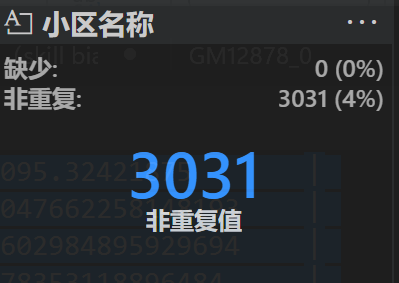

In [352]:
df =df.drop(['小区名称'], axis=1)

6、价格：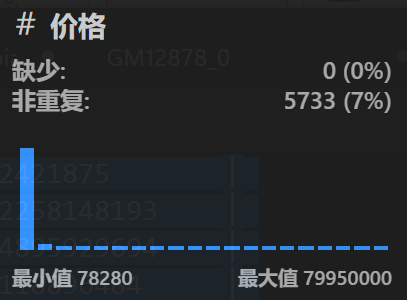

In [353]:
train_df = df[df['ID'] == -1]
pred_df = df[df['ID'] != -1]
train_df.shape, pred_df.shape

train_label = train_df['价格']

train_label = np.log(train_label)
(mu, sigma) = norm.fit(train_label)
train_df.loc[:, '价格'] = train_label  # Use .loc to avoid SettingWithCopyWarning
df = pd.concat([train_df, pred_df], axis=0)
df.shape

(98919, 42)

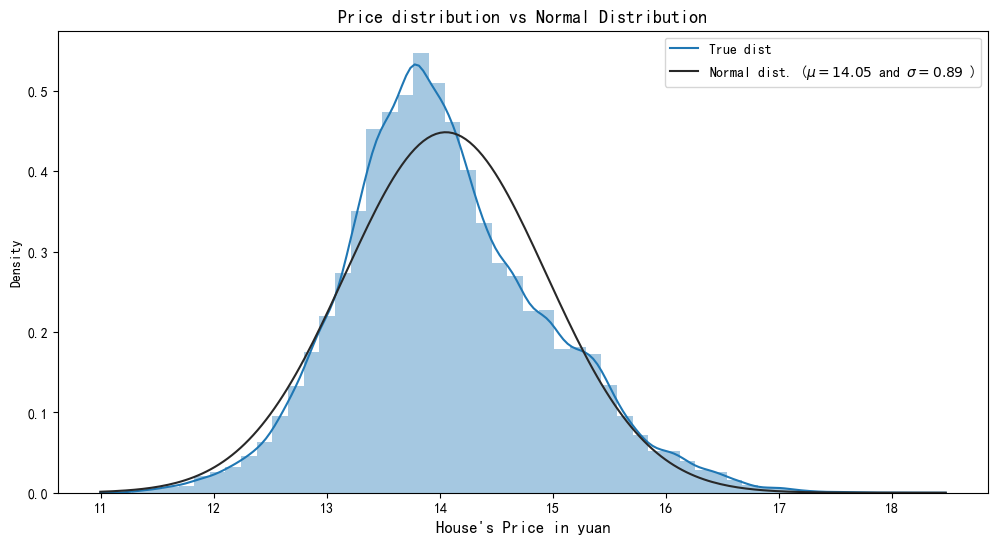

In [354]:
plt.figure(figsize=(12, 6))
sns.distplot(train_label, kde=True, fit=norm)
plt.title("Price distribution vs Normal Distribution", fontsize=13)
plt.xlabel("House's Price in yuan", fontsize=12)
plt.legend(
    [
        "True dist",
        "Normal dist. ($\mu= {:.2f}$ and $\sigma= {:.2f}$ )".format(mu, sigma)
    ],
    loc="best",
)
plt.show()

7、户型：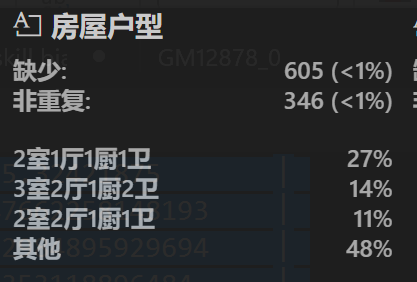

In [355]:
# 室、厅、厨、卫、房间
df['室'] = df['房屋户型'].apply(lambda x:int(x.split('室')[0]) if '室' in str(x) else 0)
df['厅'] = df['房屋户型'].apply(lambda x:int(x.split('厅')[0].split('室')[-1]) if '厅' in str(x) else 0)
df['厨'] = df['房屋户型'].apply(lambda x:int(x.split('厨')[0].split('厅')[-1]) if '厨' in str(x) else 0)
def process1(x):
    if '卫' in str(x):
        if '厨' in str(x):
            return int(x.split('卫')[0].split('厨')[-1])
        else:  # 4房间2卫
            return int(x.split('卫')[0].split('房间')[-1])
    else:
        return 0
def process2(x):
    if '房间' in str(x):
        if '卫' in str(x): # 4房间2卫
            return int(x.split('房间')[0])
        # else:
        #     return int(x.split('卫')[0].split('厅')[-1])
    else:
        return 0
df['卫'] = df['房屋户型'].apply(process1)
df['房间'] = df['房屋户型'].apply(lambda x:int(x.split('房间')[0]) if '房间' in str(x) else 0)
# 把房间加到室里
df['室'] = df['室'] + df['房间']
df = df.drop(['房间'], axis=1)
df = df.drop('房屋户型',axis=1)

8、所在楼层：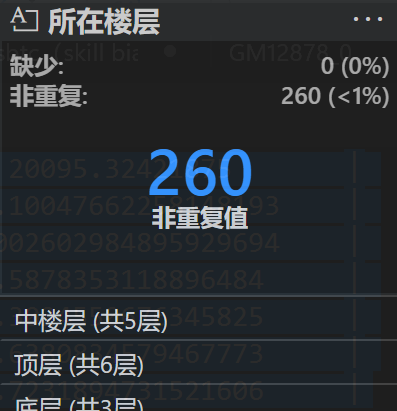

In [356]:
# print(df['所在楼层'].unique())
floor_mapping = {
    '低楼层': 1,
    '中楼层': 2,
    '高楼层': 3,
    '顶层': 4,
    '底层': 0,
    '地下室': -1
}
def process_floor(floor_str):
    # 提取楼层位置
    floor_position = re.search(r'(低楼层|中楼层|高楼层|顶层|底层|地下室)', floor_str)
    position_value = floor_mapping[floor_position.group()] if floor_position else None
    
    # 提取总楼层数
    total_floors = re.search(r'共(\d+)层', floor_str)
    total_floors_value = int(total_floors.group(1)) if total_floors else None
    
    return position_value, total_floors_value
# 应用到数据框
df[['楼层位置encode', '总楼层数']] = df['所在楼层'].apply(lambda x: pd.Series(process_floor(x)))
df,_ = class2onehot(df,'楼层位置encode')
df = df.drop(['所在楼层'], axis=1)

9~10、建筑面积+套内面积：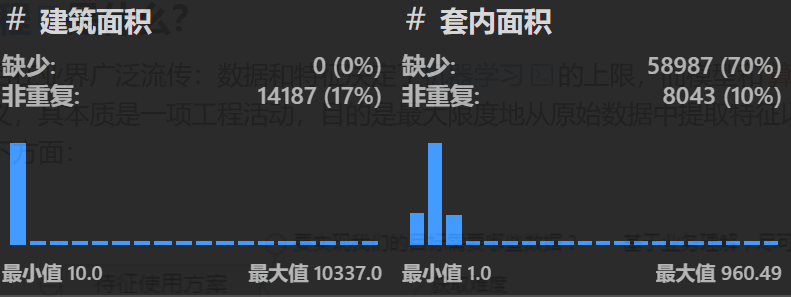

(array([2.370e+02, 1.260e+02, 2.010e+02, 8.270e+02, 1.623e+03, 2.653e+03,
        4.053e+03, 5.105e+03, 5.300e+03, 4.979e+03, 4.924e+03, 5.875e+03,
        6.770e+03, 8.063e+03, 7.223e+03, 6.505e+03, 4.151e+03, 3.485e+03,
        3.733e+03, 3.318e+03, 3.318e+03, 2.807e+03, 2.702e+03, 2.139e+03,
        1.269e+03, 1.098e+03, 8.300e+02, 7.060e+02, 5.620e+02, 3.680e+02,
        4.540e+02, 3.260e+02, 2.980e+02, 2.550e+02, 2.380e+02, 1.810e+02,
        1.680e+02, 1.460e+02, 1.560e+02, 1.420e+02, 1.220e+02, 9.000e+01,
        1.070e+02, 5.800e+01, 6.200e+01, 6.000e+01, 1.180e+02, 1.070e+02,
        7.100e+01, 5.200e+01, 5.200e+01, 7.800e+01, 4.400e+01, 3.400e+01,
        2.500e+01, 1.100e+01, 2.900e+01, 1.900e+01, 1.500e+01, 1.100e+01,
        2.200e+01, 2.600e+01, 2.300e+01, 2.300e+01, 1.400e+01, 2.900e+01,
        4.300e+01, 1.700e+01, 2.100e+01, 1.000e+01, 8.000e+00, 2.200e+01,
        1.900e+01, 7.000e+00, 6.000e+00, 1.500e+01, 1.500e+01, 8.000e+00,
        3.000e+00, 2.000e+00, 8.000e+0

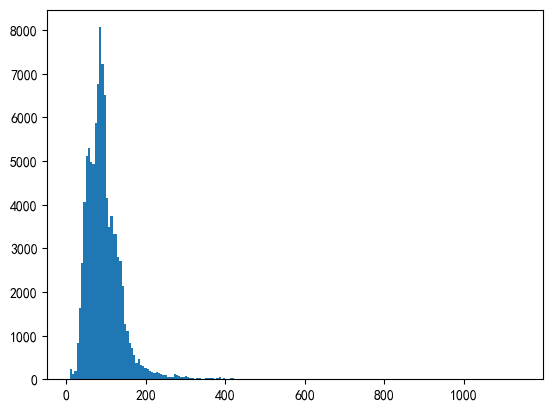

In [357]:
df=df[df['建筑面积']<1200]
plt.hist(df['建筑面积'],bins=200)

11、房屋朝向：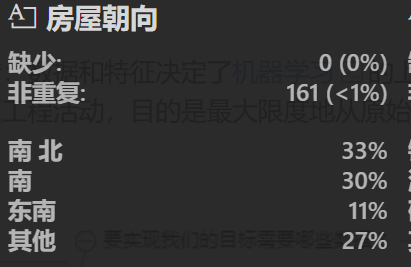

In [358]:
df['east'] = df['房屋朝向'].apply(lambda x: 1 if '东' in x else 0)
df['west'] = df['房屋朝向'].apply(lambda x: 1 if '西' in x else 0)
df['south'] = df['房屋朝向'].apply(lambda x: 1 if '南' in x else 0)
df['north'] = df['房屋朝向'].apply(lambda x: 1 if '北' in x else 0)
df.drop('房屋朝向', axis=1, inplace=True)

12~13、建筑结构+装修情况：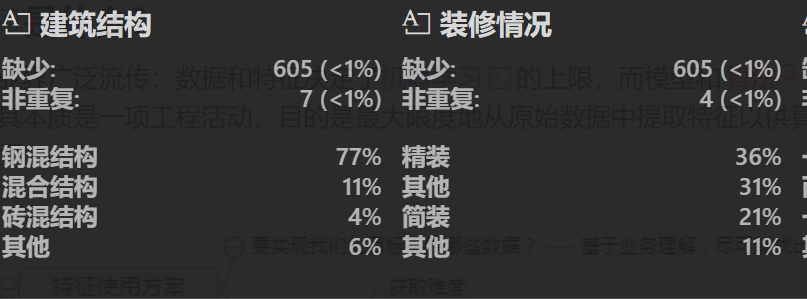

In [359]:
df,_ = class2onehot(df,'装修情况')
df,_ = class2onehot(df,'建筑结构')

14~16、梯户比例+配备电梯+别墅类型：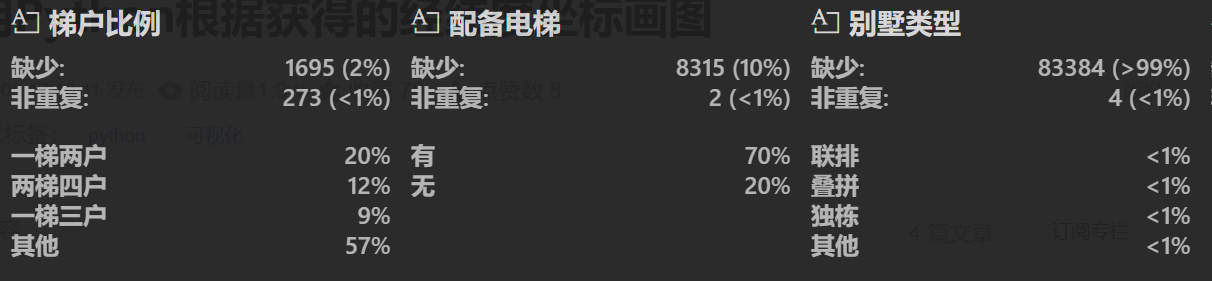

In [360]:
df['lift_ratio'] = df['梯户比例'].apply(lambda x:
                                    chinese2num_dict[x.split('梯')[0]]/chinese2num_dict[x.split('梯')[1].replace('户','')]
                                    if '梯' in str(x) else 0)
df = df.drop('梯户比例',axis=1)
df,_ = class2onehot(df,'配备电梯')
df['lift_ratio'] = df['lift_ratio']*(1-df['配备电梯_无'])
df = df.drop(['配备电梯_无'],axis=1)
# 如果别墅类型为缺失值，就是0，否则是1
df['别墅类型'] = df['别墅类型'].apply(lambda x: 0 if pd.isnull(x) else 1).astype(bool)

17+19+31、交易时间+上次交易+年份：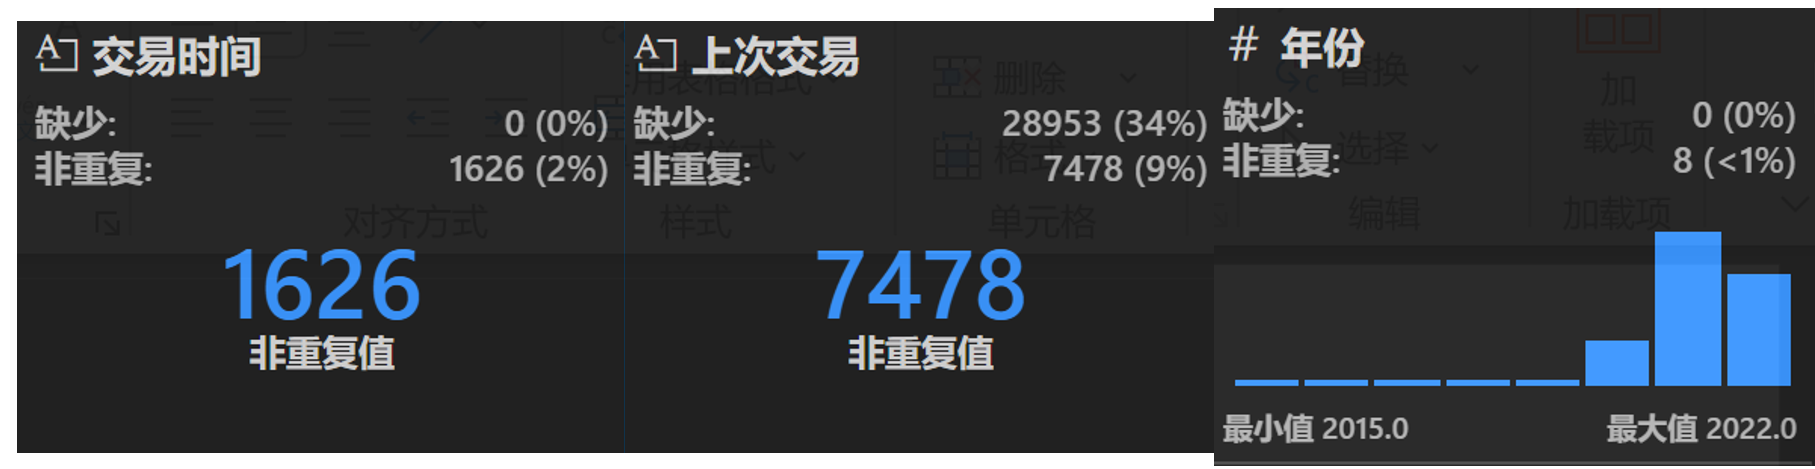

In [361]:
# drop 交易时间+上次交易+年份
list_drop = ['交易时间','上次交易','年份']
df = df.drop(list_drop,axis=1)

18+20+21：交易权属+房屋用途+房屋年限：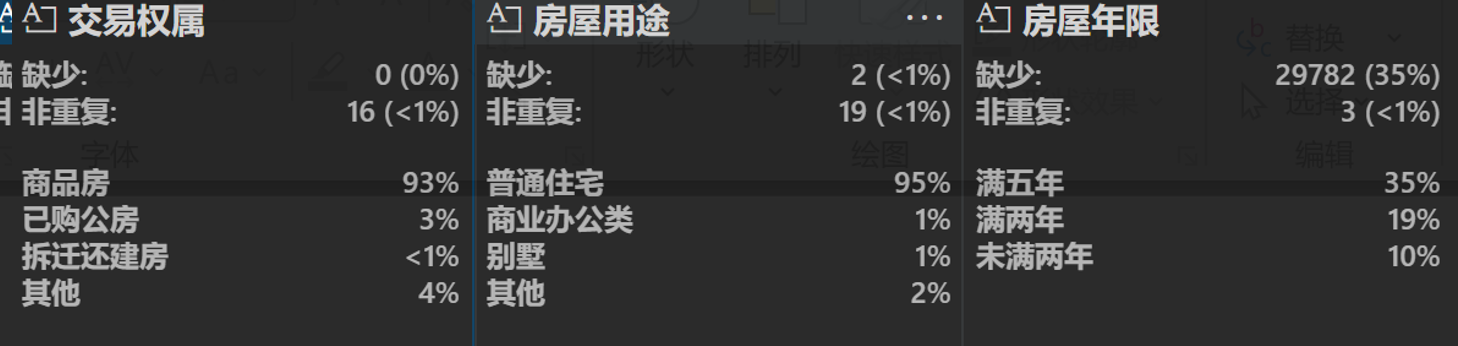

In [362]:
# drop 交易权属+房屋用途+房屋年限
list_2oh = ['交易权属','房屋用途','房屋年限']
# df = df.drop(list_drop,axis=1)
for i in list_2oh:
    df,_ = class2onehot(df,i)

22+23：产权所属+抵押信息：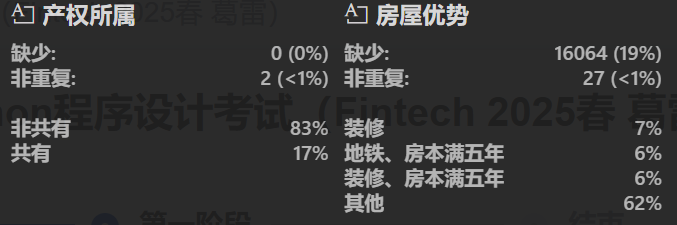

In [363]:
df,_ = class2onehot(df,'产权所属')

24~28：房屋优势+核心卖点+户型介绍+周边配套+交通出行：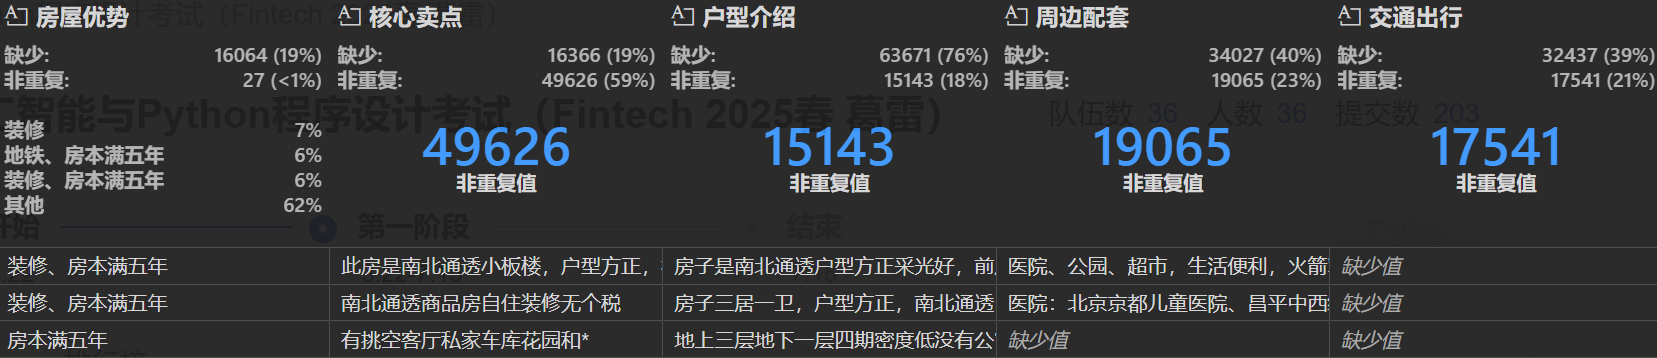

In [364]:
# 地铁、装修、房本满两年、房本满五年
# print(df['房屋优势'].unique()) 
'''['装修、房本满五年' '房本满五年' '地铁、房本满五年、' '地铁、房本满五年' '地铁、房本满两年' '、房本满五年' '房本满五年、'
 '装修、房本满两年' '房本满两年、' '装修、房本满两年、' '地铁、装修、房本满五年、' '地铁、装修、房本满五年' '、房本满两年'
 '装修、房本满五年、' '、房本满两年、' '地铁、装修、房本满两年' '房本满两年' '地铁、装修、房本满两年、' '地铁、房本满两年、'
 '、房本满五年、' nan '地铁、装修' '地铁、装修、' '地铁、' '装修' '装修、' '地铁' '、']'''
df['房屋优势'] = df['房屋优势'].fillna('')
df['地铁'] = df['房屋优势'].apply(lambda x: 1 if '地铁' in x else 0).astype(bool)
df['装修'] = df['房屋优势'].apply(lambda x: 1 if '装修' in x else 0).astype(bool)
df['房本满两年'] = df['房屋优势'].apply(lambda x: 1 if '满两年' in x else 0).astype(bool)
df['房本满五年'] = df['房屋优势'].apply(lambda x: 1 if '满五年' in x else 0).astype(bool)
df =df.drop('房屋优势',axis=1)

In [365]:
# drop户型介绍+周边配套+交通出行
list_drop = ['户型介绍','周边配套','交通出行']
df = df.drop(list_drop,axis=1)

In [366]:
#'核心卖点'
def encoding_text(df,column='核心卖点'):
    def chinese_tokenizer(text):
        return ' '.join(jieba.cut(text))

    tfidf_vectorizers = {column: TfidfVectorizer(max_features=100, tokenizer=chinese_tokenizer)}
    # 进行TF-IDF编码
    df[column] = df[column].fillna('')
    tfidf_matrix_train = tfidf_vectorizers[column].fit_transform(df[column])

    # 创建DataFrame
    tfidf_df_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=[f"{column}_tfidf_{i}" for i in range(tfidf_matrix_train.shape[1])])
    
    df = pd.concat([df, tfidf_df_train], axis=1)
    df.drop(column, axis=1, inplace=True)
    return df

df = encoding_text(df.copy(), column = "核心卖点")

29~30：lon+lat：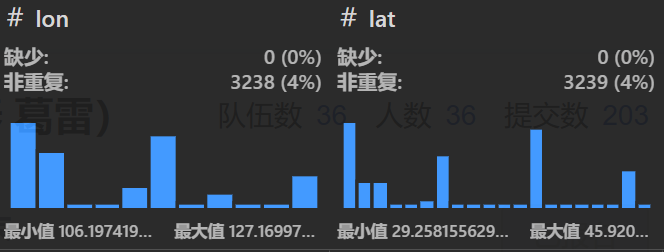

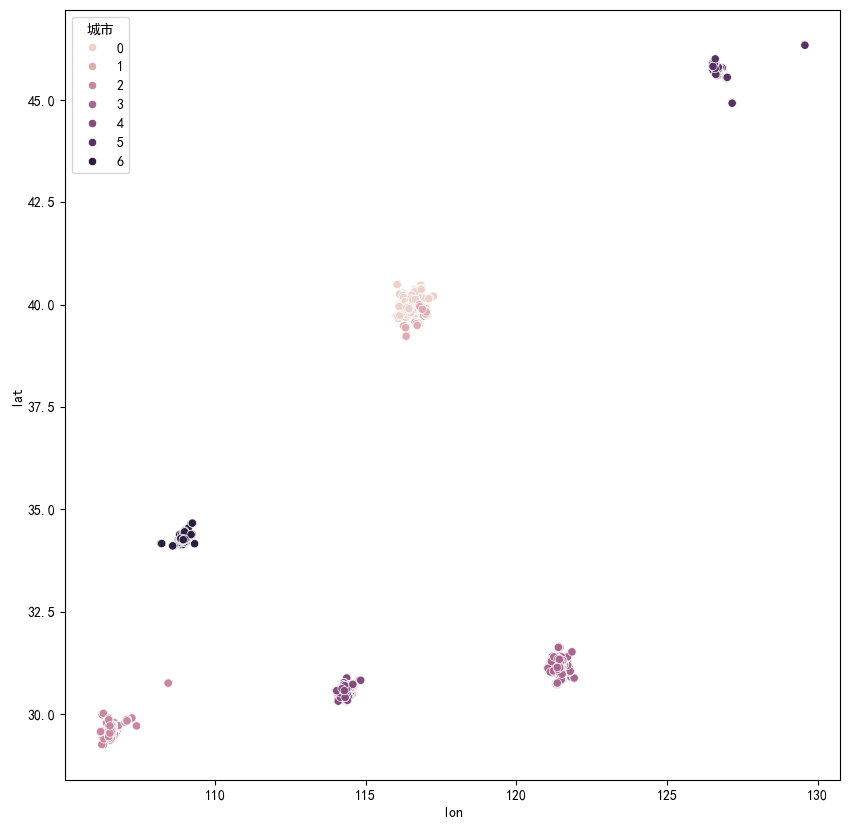

In [367]:
# 按城市分组计算经纬度的均值，并进行处理
plt.figure(figsize=(10, 10))
sns.scatterplot(x='lon', y='lat', data=df, hue='城市')
df['lat2central'] = df.groupby('城市')['lat'].transform(lambda x: (x - x.mean())**2/ x.std())
df['lon2central'] = df.groupby('城市')['lon'].transform(lambda x: (x - x.mean())**2/ x.std())
df.drop(['lat','lon'],axis=1,inplace=True)

In [368]:
# # 创建 GeoDataFrame，将经纬度转换为几何点
# df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
# gdf = gpd.GeoDataFrame(df, geometry='geometry')

# map_file = '/mnt/e/07一些资源/25大小创/25小创/数据可视化/ChinaAdminDivisonSHP-master/2. Province/province.shp'
# china_map = gpd.read_file(map_file)
# # 绘制地图和散点图
# fig, ax = plt.subplots(figsize=(12, 12))

# # 绘制行政区划地图
# china_map.plot(ax=ax, color='lightgrey', edgecolor='black',
#                legend=True,#legend_kwds={'loc': 'right', 'bbox_to_anchor': (1, 1)},
#                linewidth=0.5, alpha=0.5, zorder=1)

# # 绘制散点图，按城市区分颜色
# scatter = gdf.plot(ax=ax, markersize=10, alpha=0.8, column='城市',  cmap='tab10', zorder=2)

# # 添加经纬网格
# ax.grid(which='major', color='gray', linestyle='--', linewidth=0.5, alpha=0.7, zorder=0)
# ax.set_xticks(range(int(gdf['lon'].min()) - 1, int(gdf['lon'].max()) + 2, 2))
# ax.set_yticks(range(int(gdf['lat'].min()) - 1, int(gdf['lat'].max()) + 2, 2))
# ax.set_xticklabels([f"{x}°E" for x in ax.get_xticks()], fontsize=10)
# ax.set_yticklabels([f"{y}°N" for y in ax.get_yticks()], fontsize=10)

# # 设置标题和标签
# plt.title('城市散点图', fontsize=16)
# plt.xlabel('经度', fontsize=12)
# plt.ylabel('纬度', fontsize=12)

# # 显示图表
# plt.show()

新增的特征：

In [369]:
def clean_value(value):
    try:
        return float(value)
    except ValueError:
        return None
def process(df):
    df["供热费"] = df["供热费"].str.replace("元/㎡", "")
    df["供热费"] = df["供热费"].apply(clean_value)

    df["燃气费"] = df["燃气费"].str.replace("元/m³", "")
    df["燃气费"] = df["燃气费"].apply(clean_value)

    df["停车位"] = df["停车位"].apply(clean_value)
    df["停车费用"] = df["停车费用"].apply(clean_value)
    df["容 积 率"] = df["容 积 率"].apply(clean_value)

    df["绿 化 率"] = df["绿 化 率"].str.replace("%", "").astype(float) / 100

    df["物 业 费"] = df["物 业 费"].str.replace("元/月/㎡", "")
    df["物 业 费"] = df["物 业 费"].apply(clean_value)
    
    df["供热费"].fillna(df["供热费"].mean(), inplace=True)
    df["燃气费"].fillna(df["燃气费"].mean(), inplace=True)
    df["停车位"].fillna(df["停车位"].mean(), inplace=True)
    df["停车费用"].fillna(df["停车费用"].mean(), inplace=True)
    df["容 积 率"].fillna(df["容 积 率"].mean(), inplace=True)
    df["绿 化 率"].fillna(df["绿 化 率"].mean(), inplace=True)
    df["物 业 费"].fillna(df["物 业 费"].mean(), inplace=True)
    return df
df = process(df.copy())

In [370]:
# 除了价格全部用中位数填充
for col in df.columns:
    if col != '价格':
        df[col] = df[col].fillna(df[col].median())
    if df[col].dtype == 'object':
        df[col] = df[col].astype('bool')
for col in df.columns:
    print(col,len(df[col].unique()),df[col].dtype)

环线 10 float64
价格 5733 float64
建筑面积 14786 float64
套内面积 8558 float64
别墅类型 2 bool
ID 14787 float64
供热费 54 float64
燃气费 66 float64
停车位 701 float64
停车费用 102 float64
容 积 率 389 float64
绿 化 率 166 float64
物 业 费 190 float64
租金 687 float64
城市_0 2 bool
城市_1 2 bool
城市_2 2 bool
城市_3 2 bool
城市_4 2 bool
城市_5 2 bool
城市 7 float64
室 15 float64
厅 8 float64
厨 5 float64
卫 11 float64
总楼层数 58 float64
楼层位置encode_-1 2 bool
楼层位置encode_0 2 bool
楼层位置encode_1 2 bool
楼层位置encode_2 2 bool
楼层位置encode_3 2 bool
east 2 float64
west 2 float64
south 2 float64
north 2 float64
装修情况_其他 2 bool
装修情况_毛坯 2 bool
装修情况_简装 2 bool
建筑结构_未知结构 2 bool
建筑结构_框架结构 2 bool
建筑结构_混合结构 2 bool
建筑结构_砖木结构 2 bool
建筑结构_砖混结构 2 bool
建筑结构_钢混结构 2 bool
lift_ratio 171 float64
配备电梯_无 2 bool
交易权属_一类经济适用房 2 bool
交易权属_二类经济适用房 2 bool
交易权属_使用权 2 bool
交易权属_动迁安置房 2 bool
交易权属_售后公房 2 bool
交易权属_商品房 2 bool
交易权属_央产房 2 bool
交易权属_定向安置房 2 bool
交易权属_已购公房 2 bool
交易权属_房改房 2 bool
交易权属_拆迁还建房 2 bool
交易权属_私产 2 bool
交易权属_经济适用房 2 bool
交易权属_自住型商品房 2 bool
交易权属_限价商品房 2 bool
房屋用途_住宅式公寓 2

# 绘图

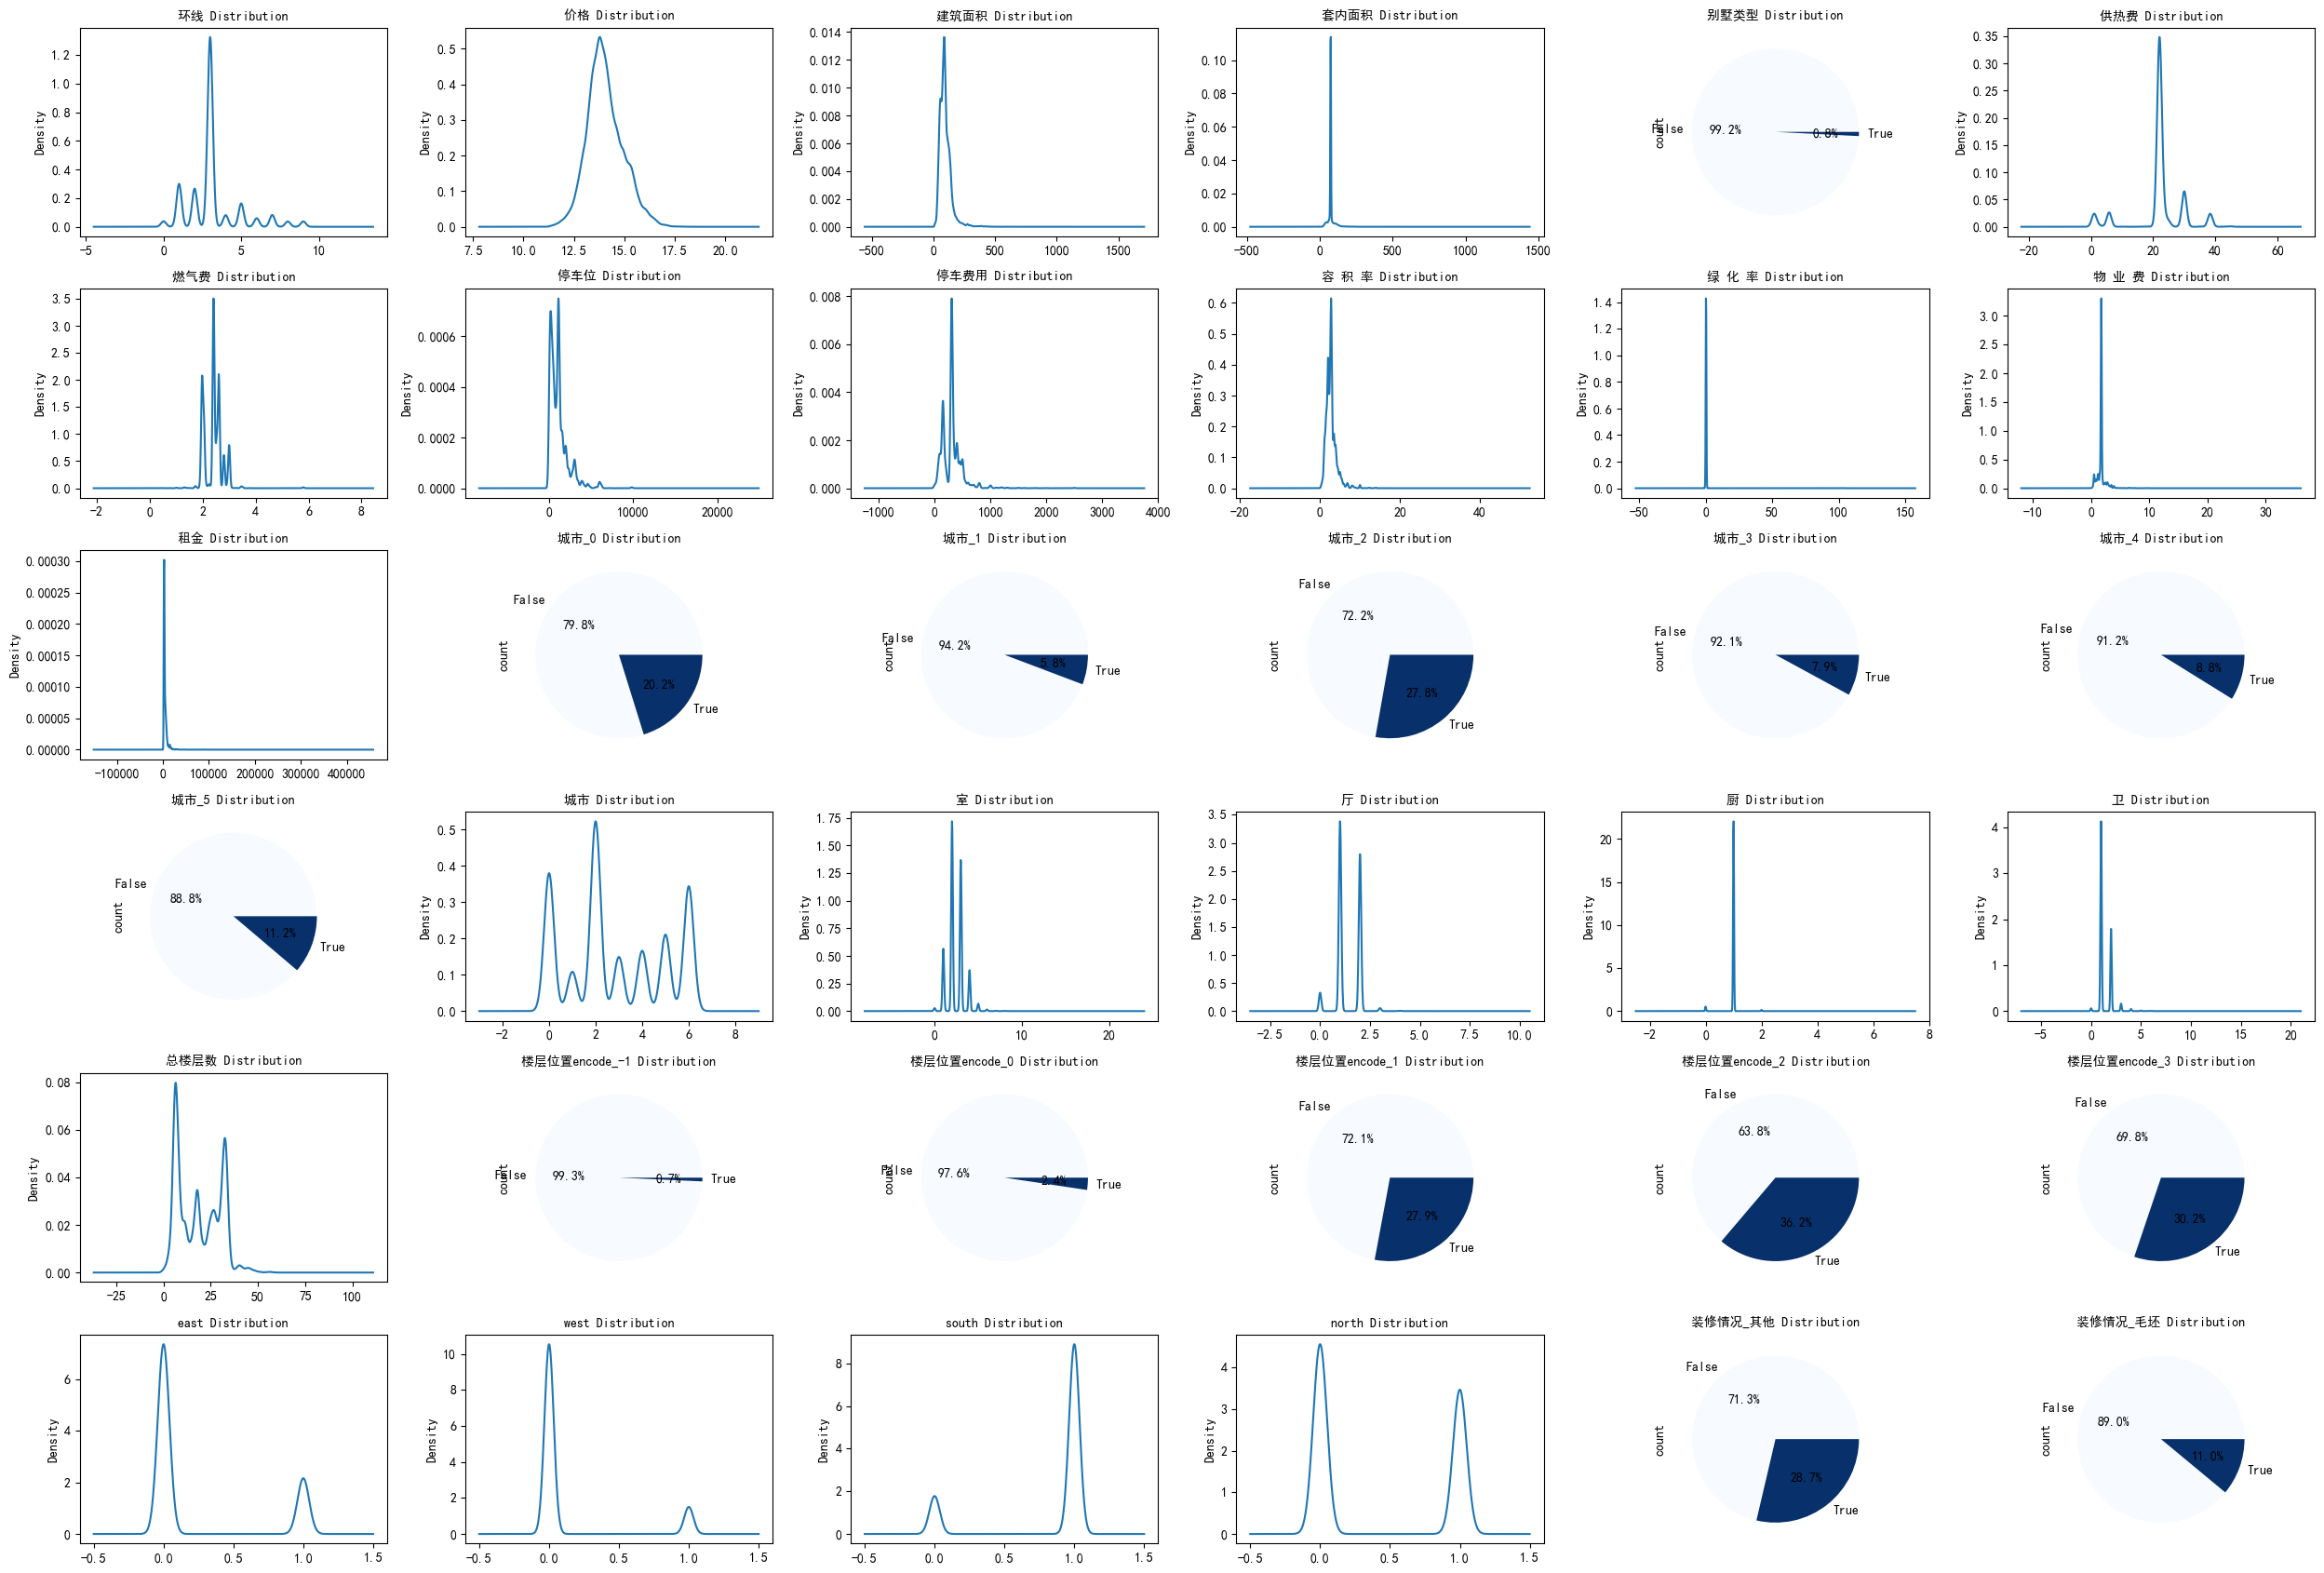

AssertionError: 

In [374]:
train_df = df[df['ID'] == -1].dropna()
train_df = train_df.drop(['ID'], axis=1)
numeric_features = train_df.columns
fig, axes = plt.subplots(nrows=6, ncols=6)
aux = 0
fig.set_figheight(17)
fig.set_figwidth(25)
for row in axes:
    for col in row:
        if '核心卖点' in numeric_features[aux]:
            continue
        if aux >= len(numeric_features):  # Avoid index errors
            break
        if df[numeric_features[aux]].dtype == 'bool':
            df[numeric_features[aux]].value_counts().plot.pie(autopct='%1.1f%%', ax=col,colormap='Blues')
            col.set_title(numeric_features[aux] + ' Distribution', fontsize=10, fontweight='bold')
        else:
            df[numeric_features[aux]].plot(kind='kde', ax=col)
            col.set_title(numeric_features[aux] + ' Distribution', fontsize=10, fontweight='bold')
        aux+=1
plt.tight_layout()
plt.show()
# correlations = train_df.corr()['价格'].drop('价格')  # 计算与价格的相关性，排除价格自身

# # 绘制相关性条形图
# plt.figure(figsize=(10, 8))
# correlations.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
# plt.title("自变量与价格的相关性", fontsize=16)
# plt.xlabel("变量", fontsize=12)
# plt.ylabel("相关系数", fontsize=12)
# # plt.xticks(rotation=90, fontsize=10)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

# 拟合

In [343]:
scaler = MinMaxScaler()
# 拆分数据集
df.drop(['城市'],axis=1,inplace=True)

train_df = df[df['ID'] == -1].dropna()
pred_df = df[df['ID'] != -1]

X = train_df.drop(['价格', 'ID'], axis=1)
y = train_df['价格']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)
# 定义模型
models = {
    'OLS': LinearRegression(),
    'LASSO': Lasso(alpha=0.08),
    'Ridge': Ridge(alpha=1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5)
}

# 初始化结果表
results = []

# 遍历模型
for name, model in models.items():
    # 训练模型
    model.fit(X_train, y_train)
    
    # In-sample 预测
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mid = median_absolute_error(y_train, y_train_pred)
    
    # Out-of-sample 预测
    y_test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mid = median_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_results = cross_validate(model, X, y, cv=6, scoring='neg_mean_absolute_error', return_train_score=True)
    cv_mae = -np.mean(cv_results['test_score'])
    cv_rmse = np.sqrt(-np.mean(cv_results['test_score']))
    # cv_mid = -np.mean(cv_results['test_score'])
    # predict
    y_pred = model.predict(pred_df.drop(['价格', 'ID'], axis=1))
    # 预测结果要取指数还原
    y_pred = np.exp(y_pred)
    result_df = pd.DataFrame({
    'ID': pred_df['ID'],
    'Price': y_pred
    })
    result_df['ID'] = result_df['ID'].astype(int)
    result_df.to_csv(f'./result/4-2.1{name}_predictions.csv', index=False, float_format='%.4f')
    
    # 保存结果
    results.append({
        'Model': name,
        'In-sample MAE': train_mae,
        'In-sample RMSE': train_rmse,
        'In-sample Median AE': train_mid,
        'Out-of-sample MAE': test_mae,
        'Out-of-sample RMSE': test_rmse,
        'Out-of-sample Median AE': test_mid,
        'Cross-validation MAE': cv_mae,
        'Cross-validation RMSE': cv_rmse
    })

# 转换为 DataFrame
results_df = pd.DataFrame(results)

# 统计总预测数量
total_predictions = len(pred_df)
print("Total predictions after removing outliers:", total_predictions)
results_df

Total predictions after removing outliers: 14786


,Model,In-sample MAE,In-sample RMSE,In-sample Median AE,Out-of-sample MAE,Out-of-sample RMSE,Out-of-sample Median AE,Cross-validation MAE,Cross-validation RMSE
0,OLS,0.240418,0.312152,0.196678,0.239445,0.311968,0.195977,0.396603,0.629765
1,LASSO,0.438334,0.589575,0.346090,0.434748,0.577007,0.345645,0.577612,0.760008
2,Ridge,0.240452,0.312167,0.196715,0.239444,0.311959,0.195852,0.396097,0.629362
3,ElasticNet,0.412551,0.555905,0.325022,0.409278,0.544242,0.322137,0.565720,0.752144


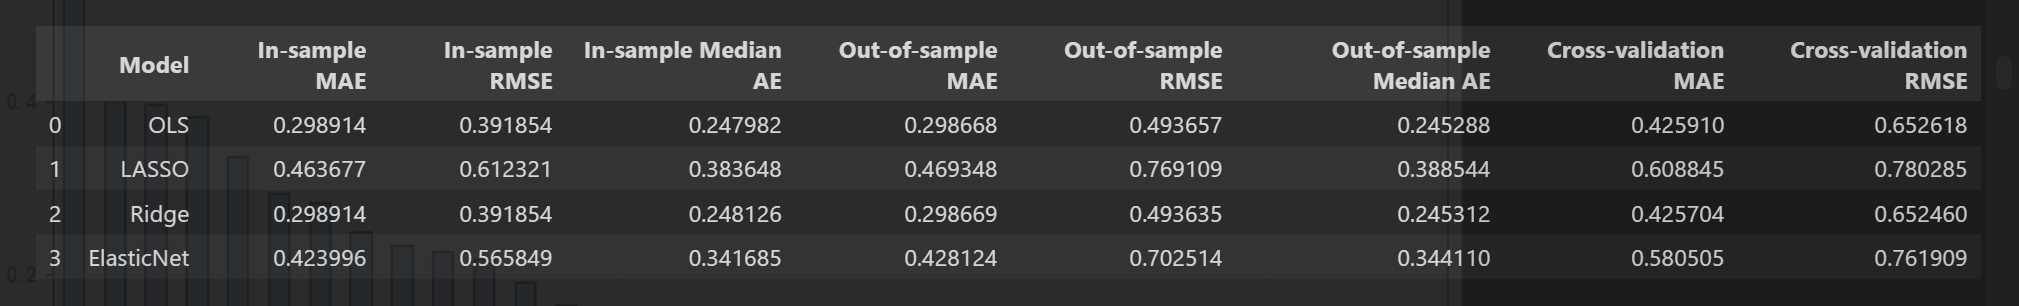

        Model  In-sample MAE  In-sample RMSE  Out-of-sample MAE  \
0         OLS       0.239437        0.310717           0.243293   
1       LASSO       0.437444        0.587682           0.444380   
2       Ridge       0.239479        0.310735           0.243294   
3  ElasticNet       0.410610        0.552845           0.416441   

   Out-of-sample RMSE  Cross-validation MAE  Cross-validation RMSE  
0            0.319328              0.395277               0.628711  
1            0.620972              0.577612               0.760008  
2            0.319314              0.394773               0.628309  
3            0.583364              0.565720               0.752144  
Total predictions after removing outliers: 14786

In [307]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 创建 LGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置 LGBM 参数
params = {
    'objective': 'regression',  # 回归任务
    'metric': 'rmse',          # 使用 RMSE 作为评估指标
    'boosting_type': 'gbdt',   # 使用梯度提升决策树
    'learning_rate': 0.1,      # 学习率
    'num_leaves': 31,          # 叶子节点数
    'max_depth': -1,           # 不限制树的深度
    'feature_fraction': 0.8,   # 每次迭代使用的特征比例
    'bagging_fraction': 0.8,   # 每次迭代使用的数据比例
    'bagging_freq': 5,         # 每 5 次迭代进行一次 bagging
    'verbose': -1              # 不输出日志
}

# 训练模型
lgbm_model = lgb.train(
    params,
    train_data,
    num_boost_round=800,       # 最大迭代次数
    valid_sets=[train_data, test_data],  # 验证集
    # early_stopping_rounds=50    # 提前停止
)

# 预测
y_train_pred = lgbm_model.predict(X_train, num_iteration=lgbm_model.best_iteration)
y_test_pred = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# 评估模型性能
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train MAE: {train_mae:.4f}, Train RMSE: {train_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}, Test RMSE: {test_rmse:.4f}")
# predict
y_pred = lgbm_model.predict(pred_df.drop(['价格', 'ID'], axis=1))
result_df = pd.DataFrame({
    'ID': pred_df['ID'],
    'Price': y_pred
})
result_df.to_csv(f'./result/LGBM_predictions.csv', index=False, float_format='%.4f')

Train MAE: 150694.6911, Train RMSE: 245720.6123
Test MAE: 188713.3728, Test RMSE: 359419.2900


In [160]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
for col in df.columns:
    if df[col].dtype == 'obejct':
        df[col] = df[col].astype('int')
    print(col,df[col].dtype)
train_df = df[df['ID'] == -1].dropna()
pred_df = df[df['ID'] != -1]

X = train_df.drop(['价格', 'ID'], axis=1)
y = train_df['价格']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 创建 LGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置 LGBM 参数
lgb_params = {
    'objective': 'regression',  # 回归任务
    'metric': 'rmse',          # 使用 RMSE 作为评估指标
    'boosting_type': 'gbdt',   # 使用梯度提升决策树
    'learning_rate': 0.1,      # 学习率
    'num_leaves': 31,          # 叶子节点数
    'max_depth': -1,           # 不限制树的深度
    'feature_fraction': 0.8,   # 每次迭代使用的特征比例
    'bagging_fraction': 0.8,   # 每次迭代使用的数据比例
    'bagging_freq': 5,         # 每 5 次迭代进行一次 bagging
    'verbose': -1              # 不输出日志
}

# 训练 LGBM 模型
lgbm_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=800,       # 最大迭代次数
    valid_sets=[train_data, test_data],  # 验证集
    # early_stopping_rounds=50    # 提前停止
)

# 训练 CatBoost 模型
catboost_model = CatBoostRegressor(
    iterations=800,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=0
)
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# 训练随机森林模型
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 预测
y_train_pred_lgbm = lgbm_model.predict(X_train, num_iteration=lgbm_model.best_iteration)
y_test_pred_lgbm = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

y_train_pred_catboost = catboost_model.predict(X_train)
y_test_pred_catboost = catboost_model.predict(X_test)

y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# 集成学习：加权平均
weights = {'lgbm': 0.4, 'catboost': 0.4, 'rf': 0.2}  # 权重可以根据验证集表现调整
y_train_pred_ensemble = (
    weights['lgbm'] * y_train_pred_lgbm +
    weights['catboost'] * y_train_pred_catboost +
    weights['rf'] * y_train_pred_rf
)
y_test_pred_ensemble = (
    weights['lgbm'] * y_test_pred_lgbm +
    weights['catboost'] * y_test_pred_catboost +
    weights['rf'] * y_test_pred_rf
)

# 评估模型性能
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse

print("Individual Model Performance:")
evaluate_model(y_train, y_train_pred_lgbm, "LGBM Train")
evaluate_model(y_test, y_test_pred_lgbm, "LGBM Test")
evaluate_model(y_train, y_train_pred_catboost, "CatBoost Train")
evaluate_model(y_test, y_test_pred_catboost, "CatBoost Test")
evaluate_model(y_train, y_train_pred_rf, "Random Forest Train")
evaluate_model(y_test, y_test_pred_rf, "Random Forest Test")

print("\nEnsemble Model Performance:")
evaluate_model(y_train, y_train_pred_ensemble, "Ensemble Train")
evaluate_model(y_test, y_test_pred_ensemble, "Ensemble Test")

# 对预测集进行预测
y_pred_lgbm = lgbm_model.predict(pred_df.drop(['价格', 'ID'], axis=1))
y_pred_catboost = catboost_model.predict(pred_df.drop(['价格', 'ID'], axis=1))
y_pred_rf = rf_model.predict(pred_df.drop(['价格', 'ID'], axis=1))

# 集成预测
y_pred_ensemble = (
    weights['lgbm'] * y_pred_lgbm +
    weights['catboost'] * y_pred_catboost +
    weights['rf'] * y_pred_rf
)

# 保存预测结果
result_df = pd.DataFrame({
    'ID': pred_df['ID'],
    'Price': y_pred_ensemble
})
result_df.to_csv(f'./result/Ensemble_predictions.csv', index=False, float_format='%.4f')

Individual Model Performance:
LGBM Train - MAE: 0.0775, RMSE: 0.1041
LGBM Test - MAE: 0.0989, RMSE: 0.1399
CatBoost Train - MAE: 0.0974, RMSE: 0.1313
CatBoost Test - MAE: 0.1058, RMSE: 0.1474
Random Forest Train - MAE: 0.1702, RMSE: 0.2297
Random Forest Test - MAE: 0.1793, RMSE: 0.2475

Ensemble Model Performance:
Ensemble Train - MAE: 0.0935, RMSE: 0.1251
Ensemble Test - MAE: 0.1065, RMSE: 0.1491


 Model  In-sample MAE  In-sample RMSE  Out-of-sample MAE  \
0    OLS  676386.527515    1.097210e+06      674012.897281   
1  LASSO  676386.272507    1.097210e+06      674012.642750   
2  Ridge  676331.870630    1.097210e+06      673962.521396   

   Out-of-sample RMSE  Cross-validation MAE  Cross-validation RMSE  
0        1.095956e+06          2.477804e+15           4.977754e+07  
1        1.095956e+06          9.120133e+05           9.549939e+02  
2        1.095968e+06          9.667729e+05           9.832461e+02  
Total predictions after removing outliers: 14786

        Model  In-sample MAE  In-sample RMSE  Out-of-sample MAE  \
0         OLS  680310.560900    1.102738e+06      677616.555869   
1       LASSO  680310.240440    1.102738e+06      677616.272411   
2       Ridge  680228.046120    1.102738e+06      677543.336050   
3  ElasticNet  710725.861815    1.246997e+06      716011.090157   

   Out-of-sample RMSE  Cross-validation MAE  Cross-validation RMSE  
0        1.103194e+06         920903.688049             959.637269  
1        1.103194e+06         920902.651694             959.636729  
2        1.103216e+06         920774.101751             959.569748  
3        1.267557e+06         964691.987595             982.187349  